In [1]:
"""
Import modules
"""

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from scipy.ndimage import measurements

%matplotlib inline

from platipy.imaging.tests.pull_data import get_lung_data
from platipy.imaging.projects.cardiac.run import run_cardiac_segmentation

In [ ]:
"""
This will download lung cancer patient CT scans, with contours of several structures.
This only has to be done once - if it is ran again don't worry, the same data will not be downloaded again!
"""

images = get_lung_data(number_of_patients=5)

In [2]:
"""
We define the settings used for the end-to-end segmentation
Check out the guide in "PlatiPy-GettingStarted.pdf" for a description of these settings
"""

settings = {
    "outputFormat": "Auto_{0}.nii.gz",
    "atlasSettings": {
        "atlasIdList": ["101","102","103"],
        "atlasStructures": ["Heart","Esophagus","Lung_L","Lung_R","SpinalCord"],
        "atlasPath": "../../imaging/tests/data/LCTSC",
        "atlasImageFormat": "LCTSC-Test-S1-{0}/CT.nii.gz",
        "atlasLabelFormat": "LCTSC-Test-S1-{0}/Struct_{1}.nii.gz",
        "autoCropAtlas":False
    },
    "autoCropSettings": {"expansion": [0,0,0],},
    "rigidSettings": {
        "initialReg": "Similarity",
        "options": {
            "shrinkFactors": [16, 8, 4],
            "smoothSigmas": [0, 0, 0],
            "samplingRate": 0.75,
            "defaultValue": -1024,
            "numberOfIterations": 15,
            "finalInterp": sitk.sitkBSpline,
            "metric": "mean_squares",
            "optimiser": "gradient_descent"
        },
        "trace": False,
        "guideStructure": False,
    },
    "deformableSettings": {
        "isotropicResample": True,
        "resolutionStaging": [16, 8, 4],  # specify voxel size (mm) since isotropic_resample is set
        "iterationStaging": [15, 15, 15],
        "smoothingSigmas": [4, 2, 1],
        "ncores": 8,
        "trace": False,
    },
    "IARSettings": {
        "referenceStructure": "Heart",
        "smoothDistanceMaps": True,
        "smoothSigma": 1,
        "zScoreStatistic": "MAD",
        "outlierMethod": "IQR",
        "outlierFactor": 1.5,
        "minBestAtlases": 5,
        "project_on_sphere": False,
    },
    "labelFusionSettings": {
        "voteType": "unweighted",
        "voteParams": {},  # No parameters needed for majority voting
        "optimalThreshold": {"Heart":0.5,
                             "Esophagus":0.5,
                             "Lung_L":0.5,
                             "Lung_R":0.5,},
    },
    "vesselSpliningSettings": {
        "vesselNameList": ["SpinalCord"],
        "vesselRadius_mm": {"SpinalCord": 6},
        "spliningDirection": {"SpinalCord": "z"},
        "stopCondition": {"SpinalCord": "count"},
        "stopConditionValue": {"SpinalCord": 1},
    },
    'returnAsCropped': False
}

In [3]:
"""
Read in the image we want to automatically segment
"""

test_image = sitk.ReadImage('../../imaging/tests/data/LCTSC/LCTSC-Test-S1-104/CT.nii.gz')

In [4]:
"""
Run autosegmentation!
This will take some time, and will print updates along the way
"""

auto_structures = run_cardiac_segmentation(test_image, settings)

2020-10-29 15:47:31.401 | INFO     | platipy.imaging.projects.cardiac.run:run_cardiac_segmentation:149 - 
2020-10-29 15:47:36.406 | INFO     | platipy.imaging.projects.cardiac.run:run_cardiac_segmentation:222 - Running initial Translation tranform to crop image volume
2020-10-29 15:47:36.408 | INFO     | platipy.imaging.projects.cardiac.run:run_cardiac_segmentation:226 -   > atlas 101
2020-10-29 15:47:54.921 | INFO     | platipy.imaging.projects.cardiac.run:run_cardiac_segmentation:226 -   > atlas 102
2020-10-29 15:48:17.377 | INFO     | platipy.imaging.projects.cardiac.run:run_cardiac_segmentation:226 -   > atlas 103
2020-10-29 15:48:41.266 | INFO     | platipy.imaging.projects.cardiac.run:run_cardiac_segmentation:269 - Calculated crop box
                [0, 0, 0]
                [509, 511, 130]

                Volume reduced by factor 1.0156151784808565
2020-10-29 15:48:41.267 | INFO     | platipy.imaging.projects.cardiac.run:run_cardiac_segmentation:282 - Running Similarity tranfo

In [ ]:
"""
Optionally write the automatic segmentations to disk
"""
output_name = settings["outputFormat"]

for struct_name in list(auto_structures.keys()):
    sitk.WriteImage(auto_structures[struct_name], output_name.format(struct_name))

In [5]:
"""
Next, we can generate a nice figure to check what the segmentation looks like

The first step here is to convert SimpleITK images to NumPy arrays
"""

image_arr = sitk.GetArrayFromImage(test_image)
auto_structures_arr = {struct:sitk.GetArrayFromImage(auto_structures[struct]) for struct in auto_structures.keys()}

In [10]:
"""
Next, we define where the orthogonal image slices will pass through, as well as the figure size and colours used for contours
"""

z,y,x = np.array(measurements.center_of_mass(auto_structures_arr['Heart']), dtype=np.int)

(SagSize, CorSize, AxSize) = test_image.GetSize()
spPlane, _, spSlice = test_image.GetSpacing()
asp = (spSlice/spPlane)

fSize = (12, 12.0*(asp*AxSize+CorSize)/(1.0*SagSize+CorSize))

color_list = plt.cm.Spectral(np.linspace(0,1,len(auto_structures_arr.keys())))

No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.
Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


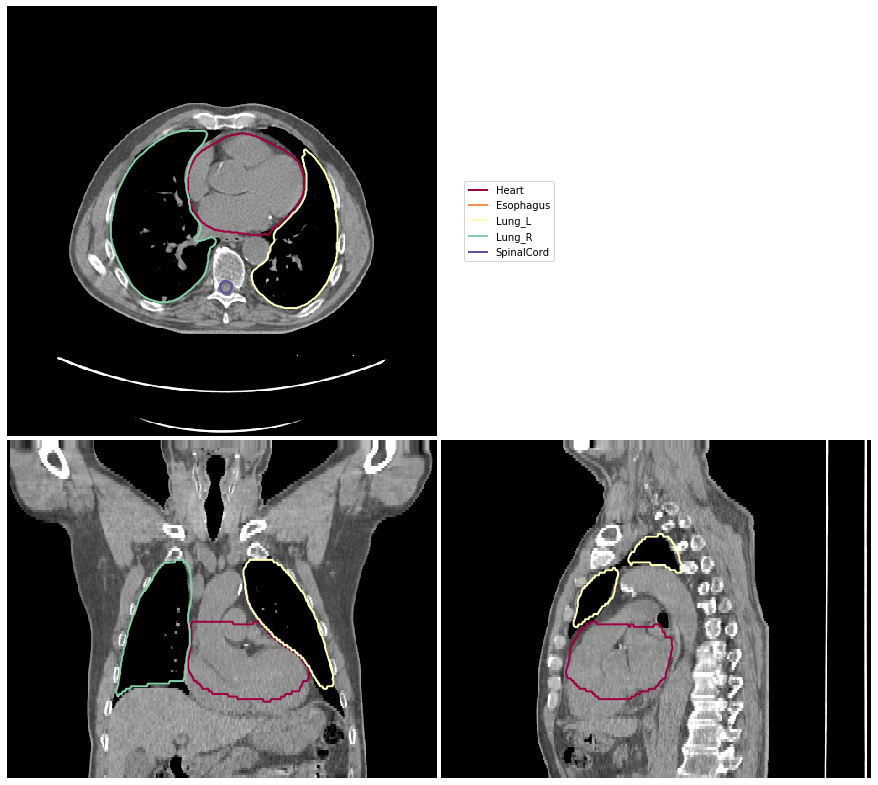

In [14]:
"""
Now generate the figure, which should be displayed below!
"""

fig, ((axAx, blank), (axCor, axSag)) = plt.subplots(2, 2, figsize=fSize,gridspec_kw = {'height_ratios':[CorSize,asp*AxSize],'width_ratios': [SagSize,CorSize]})
blank.axis('off')

imAx = axAx.imshow(image_arr[z,:,:], cmap=plt.cm.gray)
axAx.axis('off')

imCor = axCor.imshow(image_arr[:,y,:], origin='lower', aspect=asp, cmap=plt.cm.gray)
axCor.axis('off')

imSag = axSag.imshow(image_arr[:,:,x], origin='lower', aspect=asp, cmap=plt.cm.gray)
axSag.axis('off')

for i, struct in enumerate(auto_structures.keys()):
    colour = color_list[i,:3]
    temp = axAx.contour(auto_structures_arr[struct][z,:,:], levels=[0], linewidths=2, colors=[colour])
    temp.collections[0].set_label(struct)
    axCor.contour(auto_structures_arr[struct][:,y,:], levels=[0], linewidths=2, colors=[colour])
    axSag.contour(auto_structures_arr[struct][:,:,x], levels=[0], linewidths=2, colors=[colour])

vmin = -250; window=500
imAx.set_clim(vmin,vmin+window)
imCor.set_clim(vmin,vmin+window)
imSag.set_clim(vmin,vmin+window)

axAx.legend(loc='center left', bbox_to_anchor=(1.05,0.5))

fig.subplots_adjust(left=0, right=1, wspace=0.01, hspace=0.01, top=1, bottom=0)
fig.show()

In [13]:
%matplotlib inline